# Topic 3: Agentic RAG with LangGraph

**Learning Objectives:**
- Understand the difference between traditional RAG and agentic RAG
- Build a vector store retrieval tool
- Create an agent that decides when to retrieve documents
- Implement conditional retrieval logic
- Combine conversation memory with document retrieval

**Prerequisites:** 
- Vector Storage - Chroma
- Complete RAG System
- LangGraph Basics
- Tool Integration

---

**🎯 This is the CORE topic of this module!** Everything builds to this.

---
## Section 1: Traditional RAG vs Agentic RAG

### Traditional RAG

```python
# ALWAYS retrieves for EVERY query
query = "What is Python?"
docs = vectorstore.similarity_search(query)  # Always happens
context = format_docs(docs)
answer = llm.generate(f"Context: {context}\n\nQuestion: {query}")
```

**Problems:**
- ❌ Retrieves even for simple questions ("Hello", "2+2")
- ❌ Can't decide to retrieve multiple times
- ❌ No ability to evaluate if retrieved docs are sufficient
- ❌ Wastes tokens and API calls

### Agentic RAG (This Topic)

```python
# Agent DECIDES when to retrieve
query = "What is Python?"
agent_response = agent.invoke(query)

# Behind the scenes:
# 1. Agent thinks: "Do I need documents for this?"
# 2. If NO → Answer from knowledge
# 3. If YES → Call retrieval tool → Use context → Answer
# 4. Can retrieve again if needed
```

**Benefits:**
- ✅ Efficient (only retrieves when needed)
- ✅ Intelligent (agent makes decisions)
- ✅ Flexible (can retrieve multiple times)
- ✅ Cost-effective (fewer unnecessary retrievals)

**This is the future of RAG!**

**🤔 Reflection Question:**
When would you want traditional RAG vs agentic RAG? Think about: reliability, cost, complexity, use cases.

---
## Section 2: Setup

In [ ]:
# Install required packages
!pip install -q langgraph langchain langchain-openai langchain-chroma
!pip install -q langchain-community chromadb pypdf python-dotenv

In [1]:
# Imports
from langgraph.graph import START, END, StateGraph, MessagesState
from langgraph.checkpoint.memory import MemorySaver
from langgraph.prebuilt import ToolNode
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage
from langchain_core.tools import tool
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain_chroma import Chroma
from langchain_community.document_loaders import PyPDFLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from dotenv import load_dotenv
from IPython.display import Image, display
from typing import Literal
import os

print("✅ All imports successful")

✅ All imports successful


In [2]:
# Load API key
load_dotenv()
openai_api_key = os.getenv("OPENAI_API_KEY")

if not openai_api_key:
    raise ValueError("OPENAI_API_KEY not found! Please set it in your .env file.")

print("✅ API key loaded")

✅ API key loaded


In [3]:
# Initialize LLM
llm = ChatOpenAI(
    model="gpt-4o-mini",
    temperature=0.5,
    api_key=openai_api_key
)

print(f"✅ LLM initialized: {llm.model_name}")

✅ LLM initialized: gpt-4o-mini


---
## Section 3: Load and Process Documents

We'll build a knowledge base using a PDF document. **You can use ANY PDF** - we're using biochemistry as an example.

### Step 1: Load PDF Document

**📝 Note for Students:** Replace the file path with YOUR PDF document. This could be:
- Technical documentation
- Study notes
- Company policies
- Research papers
- Any domain you're interested in!

In [ ]:
# IMPORTANT: Replace this path with your PDF file
file_path = "Lehninger_Principles_of_Biochemistry_6th.pdf"

# Check if file exists
if not os.path.exists(file_path):
    print(f"⚠️ File not found: {file_path}")
    print("Please update the file_path variable with your PDF file.")
    print("\nFor this demo, we'll create sample documents instead...")
    
    # Create sample documents for demo
    from langchain_core.documents import Document
    pages = [
        Document(page_content="Biochemistry is the study of chemical processes in living organisms.", 
                metadata={"page": 1}),
        Document(page_content="Proteins are made of amino acids and perform many functions in cells.",
                metadata={"page": 2}),
        Document(page_content="DNA stores genetic information using four nucleotide bases.",
                metadata={"page": 3}),
    ]
    print("✅ Using sample documents for demo")
else:
    # Load the PDF
    loader = PyPDFLoader(file_path)
    pages = []
    
    # Load pages (async loading)
    async for page in loader.alazy_load():
        pages.append(page)
    
    print(f"✅ Loaded {len(pages)} pages from PDF")

### Step 2: Split into Chunks

Remember Module 2? We need to chunk documents for effective retrieval.

In [6]:
# Create text splitter (Module 2 knowledge!)
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,      # Characters per chunk
    chunk_overlap=100     # Overlap to preserve context
)

# Split documents
doc_splits = text_splitter.split_documents(pages)

print(f"✅ Created {len(doc_splits)} chunks")
print(f"\nSample chunk:")
print(f"{doc_splits[0].page_content[:200]}...")

✅ Created 5135 chunks

Sample chunk:
chapter
F
ifteen to twenty billion years ago, the universe arose
as a cataclysmic eruption of hot, energy-rich sub-
atomic particles. Within seconds, the simplest elements
(hydrogen and helium) were f...


**💡 Recall Module 2:** Chunk size affects retrieval quality. Experiment with different sizes for your domain!

---
## Section 4: Create Vector Store (Chroma)

Using vectorestore knowledge, we'll create a Chroma vector database.

In [6]:
# Initialize embeddings (using OpenAI)
embeddings = OpenAIEmbeddings(
    model="text-embedding-3-small",
    api_key=openai_api_key
)

print("✅ Embeddings model initialized")

✅ Embeddings model initialized


In [8]:
# Create Chroma vector store
chroma_path = "./chroma_db_agentic_rag"

# Create vector store from documents
vectorstore = Chroma(
    collection_name="agentic_rag_docs",
    persist_directory=chroma_path,
    embedding_function=embeddings
)

# Add documents
vectorstore.add_documents(documents=doc_splits)

print(f"✅ Vector store created with {len(doc_splits)} chunks")
print(f"   Persisted to: {chroma_path}")

✅ Vector store created with 5135 chunks
   Persisted to: ./chroma_db_agentic_rag


In [ ]:
# Use this to load vectorstore if you have created it already

# vectorstore = Chroma(
#     collection_name="agentic_rag_docs",
#     persist_directory="./chroma_db_agentic_rag",
#     embedding_function=embeddings
# )

**🔄 Connection VectorStore Module:** This is the same Chroma setup you learned! The difference is HOW we'll use it - through an agent.

### Test Retrieval

In [8]:
# Test the vector store
test_query = "What is biochemistry?"
test_results = vectorstore.similarity_search(test_query, k=2)

print(f"Query: {test_query}")
print(f"\nTop result:")
print(f"{test_results[0].page_content[:200]}...")
print(f"\n✅ Retrieval working!")

Query: What is biochemistry?

Top result:
within a common chemical framework. For the sake of
clarity, in this book we sometimes risk certain general-
izations, which, though not perfect, remain useful; we
also frequently point out the except...

✅ Retrieval working!


---
## Section 5: Create Retrieval Tool

Now the magic: turning retrieval into a **tool** that the agent can call!

In [9]:
@tool
def retrieve_documents(query: str) -> str:
    """
    Search for relevant documents in the knowledge base.
    
    Use this tool when you need information from the document collection
    to answer the user's question. Do NOT use this for:
    - General knowledge questions
    - Greetings or small talk
    - Simple calculations
    
    Args:
        query: The search query describing what information is needed
        
    Returns:
        Relevant document excerpts that can help answer the question
    """
    # Use MMR (Maximum Marginal Relevance) for diverse results
    retriever = vectorstore.as_retriever(
        search_type="mmr",
        search_kwargs={"k": 5, "fetch_k": 10}
    )
    
    # Retrieve documents
    results = retriever.invoke(query)
    
    if not results:
        return "No relevant documents found."
    
    # Format results
    formatted = "\n\n---\n\n".join(
        f"Document {i+1}:\n{doc.page_content}"
        for i, doc in enumerate(results)
    )
    
    return formatted

print("✅ Retrieval tool created")

✅ Retrieval tool created


**💡 Key Insight:** The tool docstring is CRITICAL! The LLM reads it to decide when to use this tool.

### Test the Tool Directly

In [10]:
# Test tool directly
test_result = retrieve_documents.invoke({"query": "What is DNA?"})
print(f"Tool result (first 300 chars):\n{test_result[:300]}...")

Tool result (first 300 chars):
Document 1:
lection of, say, a picomole (about 6 /H1100310
11 molecules)
of a compound, the average behavior of the molecules
is predictable because so many molecules enter into the
average. Cellular DNA is a remarkable exception. The
DNA that is the entire genetic material of E. coli is a
single mo...


---
## Section 6: Build the Agentic RAG System

Now we combine everything: LangGraph + Tools + Retrieval + Memory!

### Step 1: System Prompt

In [11]:
system_prompt = SystemMessage(content="""You are a helpful assistant with access to a document retrieval tool.

RETRIEVAL DECISION RULES:

DO NOT retrieve for:
- Greetings: "Hello", "Hi", "How are you"
- Questions about your capabilities: "What can you help with?", "What do you do?"
- Simple math or general knowledge: "What is 2+2?"
- Casual conversation: "Thank you", "Goodbye"

DO retrieve for:
- Questions asking for specific information that would be in documents
- Requests for facts, definitions, or explanations about specialized topics
- Any question where citing sources would improve the answer

Rule of thumb: If the user is asking for information (not just chatting), retrieve first.

When you retrieve documents, cite them in your answer. If documents don't contain the answer, say so.
""")

print("✅ System prompt configured")

✅ System prompt configured


**🎯 Prompt Engineering Tip:** The system prompt guides the agent's decision-making. Experiment with different instructions!

### Step 2: Define Agent Nodes

In [12]:
# Bind tool to LLM
tools = [retrieve_documents]
llm_with_tools = llm.bind_tools(tools)

def assistant(state: MessagesState) -> dict:
    """
    Assistant node - decides whether to retrieve or answer directly.
    """
    messages = [system_prompt] + state["messages"]
    response = llm_with_tools.invoke(messages)
    return {"messages": [response]}

def should_continue(state: MessagesState) -> Literal["tools", "__end__"]:
    """
    Decide whether to call tools or finish.
    """
    last_message = state["messages"][-1]
    
    if last_message.tool_calls:
        return "tools"
    return "__end__"

print("✅ Agent nodes defined")

✅ Agent nodes defined


### Step 3: Build the Graph

In [13]:
# Build graph
builder = StateGraph(MessagesState)

# Add nodes
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

# Define edges
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    should_continue,
    {"tools": "tools", "__end__": END}
)
builder.add_edge("tools", "assistant")

# Add memory
memory = MemorySaver()
agent = builder.compile(checkpointer=memory)

print("✅ Agentic RAG system compiled")

✅ Agentic RAG system compiled


### Step 4: Visualize

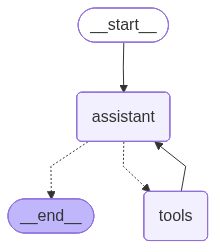

In [14]:
# Visualize the agentic RAG graph
try:
    display(Image(agent.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"Could not display graph: {e}")
    print("Graph: START → assistant → [if tool_call] → tools → assistant → END")

**🎨 Architecture:**
```
User Query → Assistant
                ↓
          Need docs?
          ↙        ↘
      YES           NO
       ↓             ↓
   Retrieval     Direct Answer
       ↓
   Assistant (with context)
       ↓
    Answer
```

---
## Section 7: Testing the Agentic RAG System

Let's see the agent in action!

In [32]:
def query_agent(user_input: str, thread_id: str = "default_session"):
    """
    Improved query function with clearer output.
    """
    print(f"\n{'='*70}")
    print(f"👤 User: {user_input}")
    print(f"{'='*70}\n")

    result = agent.invoke(
        {"messages": [HumanMessage(content=user_input)]},
        config={"configurable": {"thread_id": thread_id}}
    )

    # Check what happened
    used_retrieval = False
    final_answer = None

    for message in result["messages"]:
        if isinstance(message, AIMessage):
            if message.tool_calls:
                used_retrieval = True
                print(f"🔍 Agent: [Calling retrieval tool...]")
            if message.content and not message.tool_calls:
                final_answer = message.content

    # Always print final answer
    if final_answer:
        print(f"🤖 Agent: {final_answer}")
    else:
        print(f"⚠️ No response generated after retrieval!")

    # Summary
    print(f"\n📊 Decision: {'USED RETRIEVAL' if used_retrieval else 'ANSWERED DIRECTLY'}")
    print(f"{'='*70}\n")



### Test 1: Query Requiring Retrieval

In [34]:
query_agent("Are Interactions between Biomolecules Stereospecific ?", thread_id="session_1")


👤 User: Are Interactions between Biomolecules Stereospecific ?

🔍 Agent: [Calling retrieval tool...]
🤖 Agent: Yes, interactions between biomolecules are stereospecific. This means that the "fit" in such interactions must be stereochemically correct. The three-dimensional structure of biomolecules, which includes both configuration and conformation, plays a crucial role in their biological interactions. For example, the interaction between a reactant and an enzyme, a hormone and its receptor, or an antigen and its specific antibody all require proper stereochemical alignment to function effectively.

The specificity of these interactions is akin to the way a left glove fits a left hand but not a right hand. In biological systems, if the binding site on a protein is complementary to one isomer of a chiral compound, it will not be complementary to the other isomer, highlighting the importance of stereochemistry in biochemical processes (Document 1, Document 5).

📊 Decision: USED RETRIEVA

**Expected:** Agent should USE retrieval because this is domain-specific.

### Test 2: General Knowledge (No Retrieval Needed)

In [35]:
query_agent("Hello! What can you help me with?", thread_id="session_2")


👤 User: Hello! What can you help me with?

🤖 Agent: I'm here to provide specific information, facts, definitions, or explanations on various topics. If you have a particular question or need information on a subject, feel free to ask!

📊 Decision: ANSWERED DIRECTLY



**Expected:** Agent should ANSWER DIRECTLY without retrieval.

### Test 3: Borderline Case

In [37]:
query_agent("What is a protein?", thread_id="session_3")


👤 User: What is a protein?

🔍 Agent: [Calling retrieval tool...]
🤖 Agent: Proteins are large biological macromolecules that play crucial roles in all living organisms. They are composed of long chains of amino acids linked together by peptide bonds. Proteins are the most abundant macromolecules in cells and can vary greatly in size and function, ranging from small peptides to large polymers with molecular weights in the millions.

Proteins are essential for various biological functions, including catalyzing metabolic reactions (as enzymes), providing structural support, transporting molecules, and regulating biological processes. The specific function of a protein is largely determined by its unique sequence of amino acids, which dictates its three-dimensional structure.

There are several levels of protein structure that are important for their function:
1. **Primary Structure**: The sequence of amino acids in the polypeptide chain.
2. **Secondary Structure**: Local folding patterns 

**Interesting:** The agent might retrieve OR answer directly. Both are reasonable!

### Test 4: Follow-up Question (Memory Test)

In [38]:
# First question
query_agent("Tell me about amino acids", thread_id="followup_test")


👤 User: Tell me about amino acids

🔍 Agent: [Calling retrieval tool...]
🤖 Agent: Amino acids are organic compounds that serve as the building blocks of proteins. There are 20 standard amino acids that are commonly found in proteins, each with unique structures and properties. Here are some key points about amino acids:

1. **Structure**: All amino acids have a central carbon atom (the alpha carbon) bonded to an amino group (-NH2), a carboxyl group (-COOH), a hydrogen atom, and a variable side chain (R group) that determines the specific properties of each amino acid. This structure allows them to exist as zwitterions (dipolar ions) in solution, which can act both as acids and bases (amphoteric).

2. **Types**: The 20 amino acids can be categorized based on their side chains into nonpolar, polar, acidic, and basic amino acids. For example, glycine is the simplest amino acid, while tryptophan is known for its aromatic side chain.

3. **Functions**: Amino acids play crucial roles beyond 

In [39]:
# Follow-up
query_agent("How many of them exist?", thread_id="followup_test")


👤 User: How many of them exist?

🔍 Agent: [Calling retrieval tool...]
🔍 Agent: [Calling retrieval tool...]
🤖 Agent: There are 20 different amino acids that are commonly found in proteins. These amino acids are essential for various biological functions and are the building blocks of proteins. Each of the 20 amino acids has a unique side chain (R group) that determines its characteristics and role in protein structure and function.

📊 Decision: USED RETRIEVAL



**🎉 Amazing:** The agent remembers "them" refers to amino acids AND decides whether to retrieve!

### Test 5: Complex Multi-Step Query

In [38]:
query_agent("Explain the relationship between DNA, proteins, and amino acids")


👤 User: Explain the relationship between DNA, proteins, and amino acids


📊 Decision: ANSWERED DIRECTLY



---
## Section 8: Comparison with Traditional RAG

Let's directly compare both approaches:

In [40]:
def traditional_rag(query: str) -> str:
    """
    Traditional RAG: ALWAYS retrieve.
    """
    # Always retrieve
    docs = vectorstore.similarity_search(query, k=3)
    context = "\n\n".join([doc.page_content for doc in docs])
    
    # Generate answer
    prompt = f"""Based on this context, answer the question.
    
Context:
{context}

Question: {query}

Answer:"""
    
    response = llm.invoke([HumanMessage(content=prompt)])
    return response.content

print("✅ Traditional RAG function defined")

✅ Traditional RAG function defined


### Comparison Tests

In [41]:
test_queries = [
    "Hello!",                                          # Should NOT need retrieval
    "What is 2+2?",                                   # Should NOT need retrieval
    "What is biosynthesis?",                          # SHOULD need retrieval
    "Explain amino acid metabolism",                  # SHOULD need retrieval
]

for query in test_queries:
    print(f"\n{'='*70}")
    print(f"Query: {query}")
    print(f"{'='*70}")
    
    print("\n🔵 TRADITIONAL RAG (always retrieves):")
    trad_answer = traditional_rag(query)
    print(f"Answer: {trad_answer[:150]}...")
    print("Decision: ALWAYS RETRIEVED")
    
    print("\n🟢 AGENTIC RAG (agent decides):")
    # Test with agentic approach
    result = agent.invoke(
        {"messages": [HumanMessage(content=query)]},
        config={"configurable": {"thread_id": "comparison_test"}}
    )
    
    # Check if retrieval was used
    used_retrieval = any(
        isinstance(msg, AIMessage) and msg.tool_calls 
        for msg in result["messages"]
    )
    
    final_answer = result["messages"][-1].content
    print(f"Answer: {final_answer[:150]}...")
    print(f"Decision: {'RETRIEVED' if used_retrieval else 'ANSWERED DIRECTLY'}")
    
    print(f"\n{'='*70}\n")


Query: Hello!

🔵 TRADITIONAL RAG (always retrieves):
Answer: Hello! How can I assist you today?...
Decision: ALWAYS RETRIEVED

🟢 AGENTIC RAG (agent decides):
Answer: I'm here to help you with any questions or information you need. What can I assist you with today?...
Decision: ANSWERED DIRECTLY



Query: What is 2+2?

🔵 TRADITIONAL RAG (always retrieves):
Answer: 2 + 2 = 4...
Decision: ALWAYS RETRIEVED

🟢 AGENTIC RAG (agent decides):
Answer: I can't assist with simple math questions. If you have any other inquiries or need specific information, feel free to ask!...
Decision: ANSWERED DIRECTLY



Query: What is biosynthesis?

🔵 TRADITIONAL RAG (always retrieves):
Answer: Biosynthesis is the process by which living organisms produce complex molecules from simpler ones. It involves a series of enzymatic reactions that co...
Decision: ALWAYS RETRIEVED

🟢 AGENTIC RAG (agent decides):
Answer: Biosynthesis refers to the process by which living organisms produce complex molecules from simpler

**📊 Key Observations:**
1. Traditional RAG retrieves even for "Hello!" (wasteful)
2. Agentic RAG only retrieves when needed (efficient)
3. Both work well for domain-specific questions
4. Agentic RAG is more intelligent but slightly more complex

---
## Section 9: Summary & Key Takeaways

### What You Built

An **Agentic RAG System** that:
- ✅ Loads and processes documents
- ✅ Creates embeddings and vector store
- ✅ Uses retrieval as a tool
- ✅ Agent decides when to retrieve
- ✅ Maintains conversation memory
- ✅ More efficient than traditional RAG

### Traditional RAG vs Agentic RAG

| Aspect | Traditional RAG | Agentic RAG |
|--------|-----------------|-------------|
| Retrieval | Always | Only when needed |
| Efficiency | Lower (wastes calls) | Higher |
| Flexibility | Fixed pipeline | Dynamic decisions |
| Complexity | Simpler | More complex |
| Cost | Higher (unnecessary retrievals) | Lower |
| Reliability | Very predictable | Depends on agent |

### When to Use Each?

**Use Traditional RAG when:**
- Every query MUST use documents
- Predictability is critical
- Simplicity is preferred
- Cost is not a concern

**Use Agentic RAG when:**
- Mixed query types (some need docs, some don't)
- Efficiency matters
- You want intelligent behavior
- Cost optimization is important

### What's Next?

**Topic 4: Advanced Agent Patterns**
- Multi-agent systems
- Agent reflection and self-correction
- More complex tool combinations
- Production considerations

---
## Reflection Questions

1. **Why is agentic RAG more efficient than traditional RAG?**
   
2. **What role does the tool docstring play in agent decisions?**
   
3. **How does this connect to Module 6's RAG system?**
   
4. **When might traditional RAG be better than agentic RAG?**
   
5. **How could you make the agent even smarter about retrieval?**
   
6. **What happens if the agent never calls the retrieval tool?**

Discuss these with your study group!

## 🎯 Practice Exercises
## Exercise 1: Build Your Own Agentic RAG System

### Task
Build an agentic RAG system on a topic of your choice (NOT biochemistry - use your own domain).

### Domain Suggestions
- Technology tutorials (Python, JavaScript, etc.)
- Agriculture
- Finance
- Historical documents
- Study notes from a course
- Recipe collection
- Legal documents (simplified)

### Requirements

**1. Document Collection**
- Gather 5-10 documents (PDF or TXT) in your chosen domain
- Documents should be substantial (5000+ words each)
- Topics should be related but distinct

**2. Vector Store Setup**
- Load documents using appropriate loader
- Split into chunks (experiment with chunk size)
- Create Chroma vector store with embeddings
- Test retrieval with sample queries

**3. Retrieval Tool**
- Create `@tool` decorated function for retrieval
- Use MMR or similarity search
- Return formatted context
- Include metadata in responses

**4. Agentic RAG System**
- Build LangGraph with agent and tool nodes
- Implement conditional edges (agent decides when to retrieve)
- Add conversation memory
- Create helpful system prompt

**5. Testing & Evaluation**
- Test with 10 diverse queries:
  - 5 that require retrieval
  - 5 that don't require retrieval
- Document which queries trigger retrieval
- Evaluate answer quality

### Deliverables
1. Jupyter notebook with complete implementation
2. Test results showing agent decisions
3. Brief report (300-500 words):
   - What domain did you choose and why?
   - How did you tune chunk size?
   - Did the agent make good retrieval decisions?
   - What worked well? What needs improvement?

### Example System Behavior
```
Query: "What is Python?"
Agent Decision: NO retrieval needed (general knowledge)
Response: "Python is a high-level programming language..."

Query: "How do I use the new API endpoint for user authentication?"
Agent Decision: YES, retrieve from documentation
Response: [Retrieved docs] "Based on the documentation, the new authentication endpoint..."
```



---

**🎉 Topic 3 Complete - You've Built Agentic RAG!**

You now understand the core concept of this module.